# Test X2 & X2: Prediction with Full Covariance Matrix CPU

These test capture the runtime for the Cholesky decomposition with GPRat on the CPU.
We use a fixed problem size of $32768=2^{15}$, an increasing number of tiles in $\{1,2,4,8,16,32,64,128,256,512\}$, an increasing number of cores in $\{6,12,24,48\}$, 8 regressors and loop 10 times.
Note that we do not account for the time it takes to return the data to the callee.

Findings:

- There is no optimal number of cores. Therefore, we will use 48 cores for the other tests.
- ...

In [2]:
# setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import utils
import math

import warnings

warnings.filterwarnings("ignore")

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams.update({"font.size": 11})
mpl.rcParams.update({"errorbar.capsize": 5})
mpl.rcParams.update({"grid.linewidth": 0.5})
mpl.rcParams.update({"legend.fontsize": 9})


def figsize(x, y, y_log_min=1, y_log_max=1):
    """
    Set figsize based on same bounding box to achive shared axes
    """
    x_const = 0.5421892781575521
    y_const = 0.8417361111111112
    return (
        x + x_const,
        (y + math.log10(y_log_max) - math.log10(y_log_min)) * 1 + y_const,
    )


# bbox = ax.get_position()
# fig_width, fig_height = fig.get_size_inches()
# print((1 - (bbox.x1 - bbox.x0)) * fig_width, (1 - (bbox.y1 - bbox.y0)) * fig_height)

In [3]:
def mean_stddev(df, groupby_cols):
    new_df = df[df["i_loop"] != 0]
    new_df = (
        new_df.groupby(groupby_cols)["time"]
        .agg(["mean", "std", "count"])
        .reset_index()
    )
    new_df.rename(columns={"std": "stddev", "count": "n_loops"}, inplace=True)
    return new_df

In [4]:
df_full = pd.read_csv("./data/X1/output-cpu.csv")
df_full = mean_stddev(df_full, ["n_cores", "n_train", "n_test", "n_tiles", "n_reg"])

In [5]:
# load data

apex_dir_steps = "./data/X2/"

names_steps = [
    "predict_full_cov_step assembly",
    "predict_full_cov_step cholesky",
    "predict_full_cov_step forward",
    "predict_full_cov_step backward",
    "predict_full_cov_step forward KcK",
    "predict_full_cov_step prediction",
    "predict_full_cov_step full cov",
    "predict_full_cov_step pred uncer",
    "assemble K_tiles",
    "assemble alpha_tiles",
    "assemble prior_K_tiles_full",
    "assemble cross_covariance_tiles",
    "assemble t_cross_covariance_tiles",
    "assemble zeros",
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
    "forward trsv",
    "forward gemv",
    "backward trsv",
    "backward gemv",
    "forward_KcK trsm",
    "forward_KcK gemm",
    "predict gemv",
    "full_cov gemm",
    "pred_uncer diag_tile",
]

file_headers = ["n_cores", "n_train", "n_test", "n_tiles", "n_reg", "n_loops"]

def apex_files_to_df(dir, names):
    data = []
    for filename in os.listdir(dir):
        if filename.endswith(".csv"):
            parts = filename.replace("apex_profiles_", "").replace(".csv", "").split("_")
            file_params = dict(zip(file_headers, map(int, parts)))
            file_path = os.path.join(dir, filename)
            df = pd.read_csv(file_path)
            df = df[df['name'].isin(names)]
            for key, value in file_params.items():
                df[key] = value
            data.append(df)
    df_combined = pd.concat(data, ignore_index=True)
    df_combined = df_combined.sort_values(by='n_tiles')
    return df_combined

df_steps = apex_files_to_df(apex_dir_steps, names_steps)

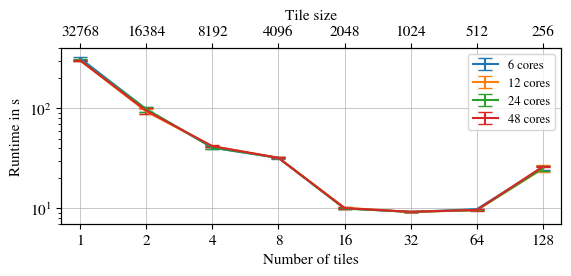

In [6]:
# plot for predict full cov

n_train = 32768

fig, ax = plt.subplots(figsize=figsize(5, 1, 7, 40))
ax_top = ax.twiny()

xticks = df_full["n_tiles"].unique()
tile_sizes = n_train / xticks
ax.set_xlabel("Number of tiles")
ax.set_ylabel("Runtime in s")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(which="both")
ax.grid(False, which="minor")
ax.set_xlim(0.82, 155)
ax.set_ylim(7*10**0, 4*10**2)

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

for n_cores, group in df_full.groupby("n_cores"):
    err = utils.confidence_error(group, 0.95)
    plt.errorbar(group['n_tiles'], group['mean'], yerr=err, label=f"{n_cores} cores")

plt.legend()
plt.tight_layout(pad=0.1)
# plt.savefig("./pdf/predict-fullcov-cpu.pdf")

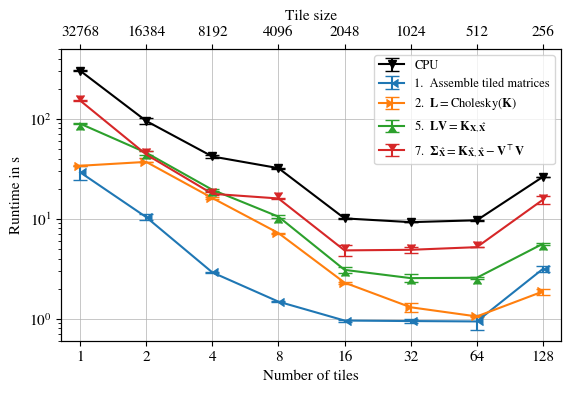

In [8]:
# plot for predict fullcov steps

n_train = 32768
n_cores = 48

fig, ax = plt.subplots(figsize=figsize(5, 3, 6, 5))

ax.set_xlabel("Number of tiles")
ax.set_ylabel("Runtime in s")
ax.set_xlim(0.82, 155)
ax.set_ylim(6*10**-1, 5*10**2)

xticks = df_steps["n_tiles"].unique()
tile_sizes = n_train / xticks

ax_top = ax.twiny()

xticks = df_full["n_tiles"].unique()
tile_sizes = n_train / xticks

ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(which="both")
ax.grid(False, which="minor")

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

df_full_48 = df_full[df_full["n_cores"] == n_cores]
err = utils.confidence_error(df_full_48, 0.95)
ax.errorbar(
    df_full_48["n_tiles"],
    df_full_48["mean"],
    yerr=err,
    color="black",
    label=r"CPU",
    marker="v"
)

names = [
    "predict_full_cov_step assembly",
    "predict_full_cov_step cholesky",
    # "predict_full_cov_step forward",
    # "predict_full_cov_step backward",
    "predict_full_cov_step forward KcK",
    # "predict_full_cov_step prediction",
    "predict_full_cov_step full cov",
]

labels = [
    r"1.  Assemble tiled matrices",
    r"2.  $\mathbf{L} = \text{Cholesky}(\mathbf{K})$",
    # r"3.  $\mathbf{L\beta} = \mathbf{y}$",
    # r"4.  $\mathbf{L^\top\alpha} = \mathbf{\beta}$",
    r"5.  $\mathbf{LV} = \mathbf{K}_{\mathbf{X},\mathbf{\hat X}}$",
    # r"6.  $\mathbf{\hat y} = \mathbf{K}_{\mathbf{\hat X},\mathbf{X}}\mathbf{\alpha}$",
    r"7.  $\mathbf{\Sigma}_{\mathbf{\hat X}} = \mathbf{K}_{\mathbf{\hat X},\mathbf{\hat X}} - \mathbf{V}^\top \mathbf{V}$",
]

markers = [4,5,6,7]

for name, label, marker in zip(names, labels, markers):
    df_name = df_steps[df_steps["name"] == name]
    df_name["mean"] = df_name["mean"].values
    err = utils.confidence_error(df_name, 0.95)
    ax.errorbar(
        df_name["n_tiles"],
        df_name["mean"] / 10**9,
        yerr=err / 10**9,
        # color=color,
        label=label,
        marker=marker,
    )

ax.legend()
fig.tight_layout(pad=0.1)
fig.savefig("./pdf/predict-fullcov-cpu-steps.pdf")